In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from os import path
from PIL import Image

# import plotly modules
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls

%matplotlib inline

In [7]:
world_cups = pd.read_csv('../data/WorldCups.csv')
world_cup_player = pd.read_csv('../data/WorldCupPlayers.csv')
world_cups_matches = pd.read_csv('../data/WorldCupMatches.csv')

In [8]:
#DROP NA VALUES
world_cup_player = world_cup_player.dropna()
world_cups = world_cups.dropna()
world_cups_matches = world_cups_matches.dropna()

In [9]:
world_cups = world_cups.replace('Germany FR', 'Germany')
world_cup_player = world_cup_player.replace('Germany FR', 'Germany')
world_cups_matches = world_cups_matches.replace('Germany FR', 'Germany')

In [10]:
winner_by_score_home = (
    world_cups_matches["Home Team Goals"] > world_cups_matches["Away Team Goals"]
)
winner_by_score_away = (
    world_cups_matches["Home Team Goals"] < world_cups_matches["Away Team Goals"]
)
win_by_score = winner_by_score_home | winner_by_score_away
win_penalties = world_cups_matches["Win conditions"].str.len() > 1

win_team_home = np.where(winner_by_score_home, world_cups_matches["Home Team Name"], "")
win_team_away = np.where(winner_by_score_away, world_cups_matches["Away Team Name"], "")

win_cond = world_cups_matches["Win conditions"].str.split(pat="\(|\)|-", expand=True)
win_team_penalties = np.where(
    win_cond[0].str.len() > 1,
    np.where(
        win_cond[1] > win_cond[2],
        world_cups_matches["Home Team Name"],
        world_cups_matches["Away Team Name"],
    ),
    "",
)

win_team = np.where(
    win_team_home != "",
    win_team_home,
    np.where(win_team_away != "", win_team_away, win_team_penalties),
)

world_cups_matches.loc[:, "result"] = np.where(
    win_by_score, "win", np.where(win_penalties, "win", "draw")
)
world_cups_matches.loc[:, "Winner"] = win_team
world_cups_matches.loc[:, "Looser"] = np.where(
    world_cups_matches["result"] != "draw",
    np.where(
        win_team == world_cups_matches["Home Team Name"],
        world_cups_matches["Away Team Name"],
        world_cups_matches["Home Team Name"],
    ),
    "",
)

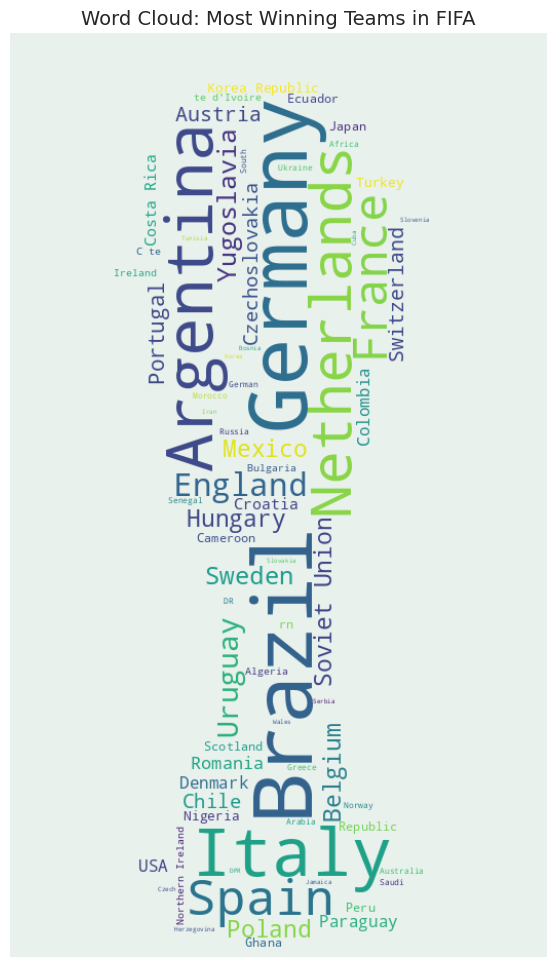

In [24]:
cup_mask = np.array(Image.open("../data/FIFA_Trophy_Mask.jpg"))

# Define custom background color for the WordCloud
background_color = "#e9f1ed"

wc_cup = WordCloud(background_color=background_color, max_words=2000, mask=cup_mask)

winner_text = " ".join(world_cups_matches["Winner"].dropna().tolist())

wc_cup.generate(winner_text)

plt.figure(figsize=(21, 12))
sns.set_style("whitegrid")

# Set background color for the entire plot
plt.rcParams["axes.facecolor"] = background_color

plt.title("Word Cloud: Most Winning Teams in FIFA", fontsize=14)
plt.imshow(wc_cup, interpolation="bilinear")
plt.axis("off")

# Exporting the plot and saving it in the same folder as a JPG file with the same background color
plt.savefig("./WCWinners_wordcloud.jpg", format="jpg", facecolor=background_color)

plt.show()